INFO: Starting weather data comparison analysis from local files...
INFO: Processing Jefferson data from local file...
INFO: Jefferson data columns: ['Date Data', 'Location Data', 'Time Data', 'Fahrenheit Temperature Data', 'Reaumur Temperature Transcribed', 'Barometer Data', 'Hygrometer Unspecified', 'Hygrometer (DeLuc)', 'Hygrometer (Saussure)', 'Wind Direction Data', 'Wind Force', 'Precipitation Amount', 'Snow Depth', 'Weather Conditions', 'Season', 'Animals', 'Plants', 'Observer', 'Jefferson Notes']
INFO: Jefferson data processed: 213 monthly records
INFO: Processing BLACKVILLE 3W  data from local file...
INFO: BLACKVILLE 3W  columns: ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'DAEV', 'DAEV_ATTRIBUTES', 'DAPR', 'DAPR_ATTRIBUTES', 'DASF', 'DASF_ATTRIBUTES', 'DAWM', 'DAWM_ATTRIBUTES', 'EVAP', 'EVAP_ATTRIBUTES', 'MDEV', 'MDEV_ATT

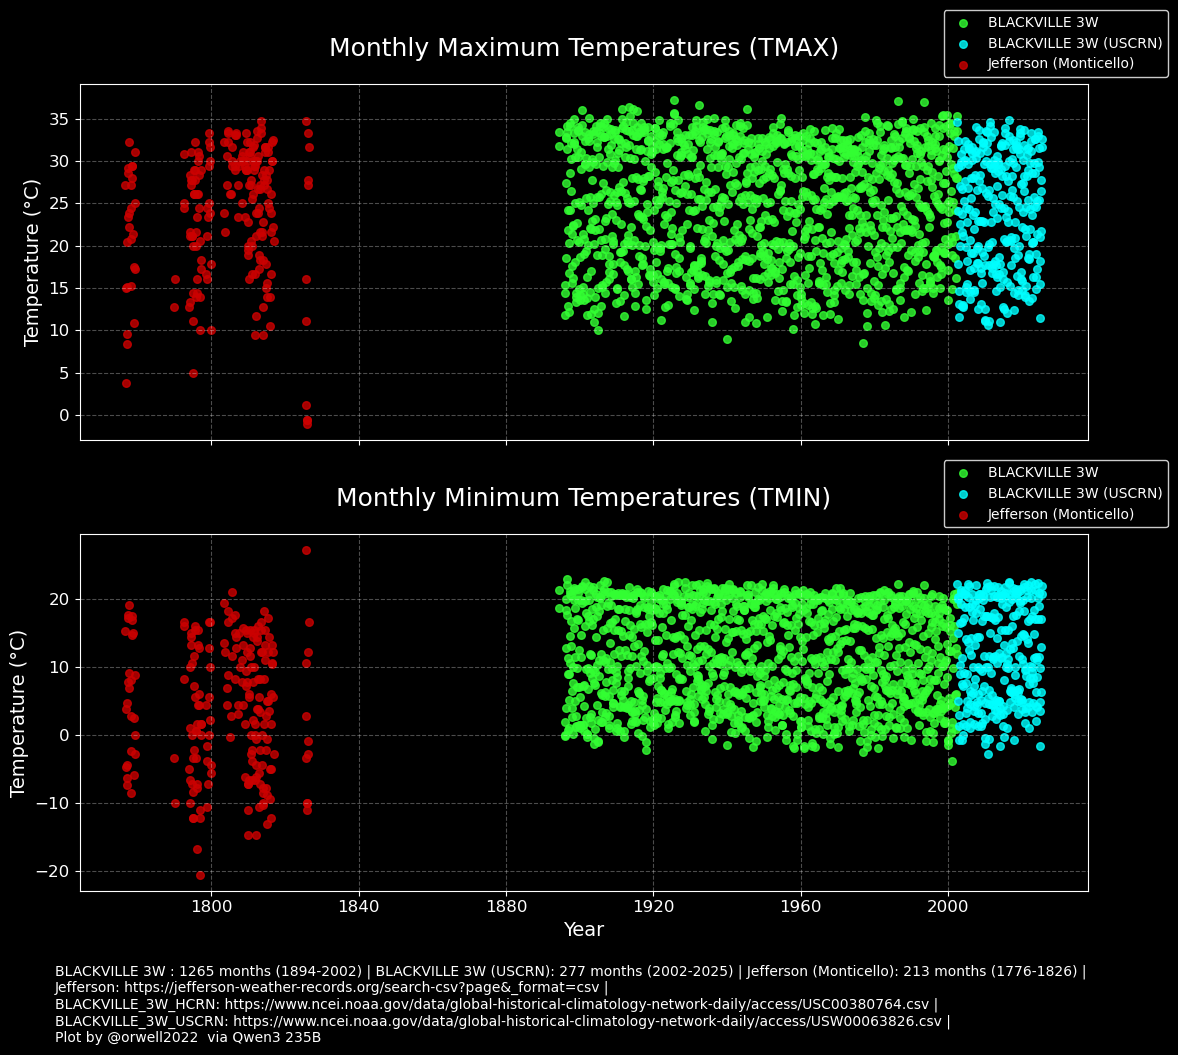

INFO: Creating daily plot with 55636 records


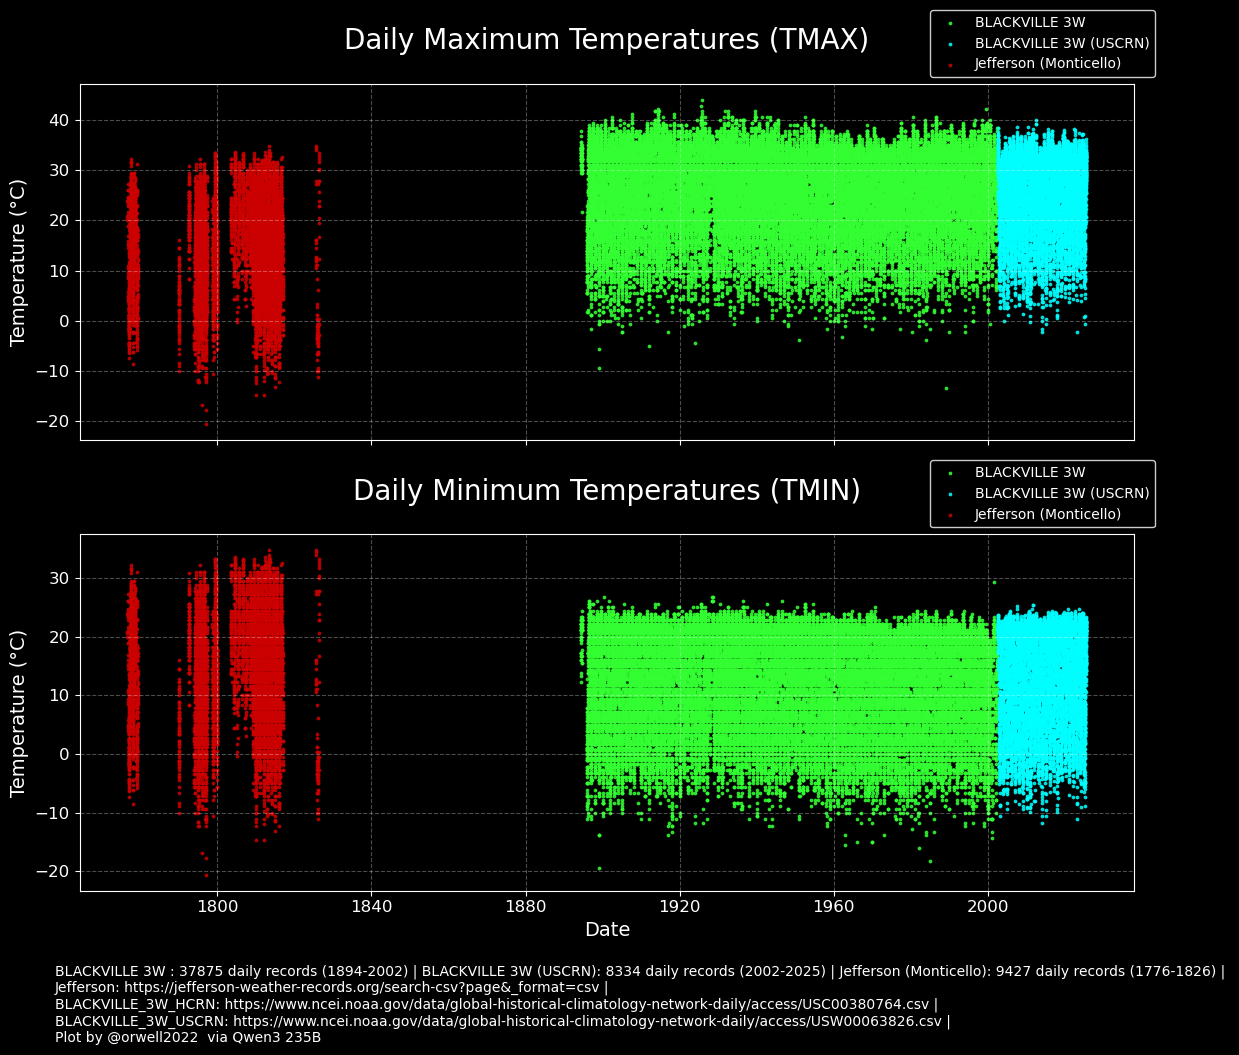

In [71]:
# Jefferson vs USCRN vs Legacy DC – Monthly & Daily TMAX and TMIN Comparison
import pandas as pd
import matplotlib.pyplot as plt
import logging
from datetime import datetime
import numpy as np

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

def process_jefferson_data():
    """Process Jefferson weather data from local CSV"""
    logger.info("Processing Jefferson data from local file...")
    
    try:
        file_path = r"C:\Users\Administrator\Downloads\jefferson.csv"
        df_jeff = pd.read_csv(file_path)
    except Exception as e:
        logger.error(f"Failed to read Jefferson data: {e}")
        return pd.DataFrame()
    
    logger.info(f"Jefferson data columns: {df_jeff.columns.tolist()}")
    
    # Identify columns
    location_col = next((col for col in df_jeff.columns if 'location' in col.lower()), None)
    date_col = next((col for col in df_jeff.columns if 'date' in col.lower()), None)
    temp_col = next((col for col in df_jeff.columns if 'temp' in col.lower() and 'fahrenheit' in col.lower()), None)
    
    if not all([location_col, date_col, temp_col]):
        logger.error(f"Missing required columns in Jefferson data")
        return pd.DataFrame()
    
    try:
        # Filter for Monticello
        df_jeff = df_jeff[df_jeff[location_col].str.contains("Monticello", na=False, case=False)]
        
        if df_jeff.empty:
            df_jeff = pd.read_csv(file_path)
            logger.info("Using all Jefferson data without location filter")
        
        # Clean and convert data
        df_jeff = df_jeff.dropna(subset=[temp_col])
        df_jeff['Date'] = pd.to_datetime(df_jeff[date_col], errors='coerce')
        df_jeff = df_jeff.dropna(subset=['Date'])
        
        # Convert to Celsius
        df_jeff['Celsius'] = (df_jeff[temp_col] - 32) * 5.0 / 9.0
        
        # Monthly aggregation
        df_jeff['Month'] = df_jeff['Date'].dt.to_period('M')
        monthly_jeff = df_jeff.groupby('Month')['Celsius'].agg(
            TMAX_C='max', TMIN_C='min'
        ).reset_index()
        
        monthly_jeff['Date'] = monthly_jeff['Month'].dt.to_timestamp()
        monthly_jeff['Source'] = 'Jefferson (Monticello)'
        monthly_jeff['Type'] = 'Monthly'
        
        # Daily data for new plot
        daily_jeff = df_jeff.copy()
        daily_jeff['TMAX_C'] = daily_jeff['Celsius']
        daily_jeff['TMIN_C'] = daily_jeff['Celsius']
        daily_jeff['Type'] = 'Daily'
        daily_jeff['Source'] = 'Jefferson (Monticello)'
        
        logger.info(f"Jefferson data processed: {len(monthly_jeff)} monthly records")
        return monthly_jeff[['Date', 'TMAX_C', 'TMIN_C', 'Source', 'Type']], daily_jeff[['Date', 'TMAX_C', 'TMIN_C', 'Source', 'Type']]
        
    except Exception as e:
        logger.error(f"Error processing Jefferson data: {e}")
        return pd.DataFrame(), pd.DataFrame()

def process_ghcn_data(file_path, source_name):
    """Process GHCN data from local CSV"""
    logger.info(f"Processing {source_name} data from local file...")
    
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        logger.error(f"Failed to read {source_name} data: {e}")
        return pd.DataFrame(), pd.DataFrame()
    
    logger.info(f"{source_name} columns: {df.columns.tolist()}")
    
    # Check required columns
    required_cols = ['DATE', 'TMAX', 'TMIN']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        logger.error(f"{source_name} data missing columns: {missing_cols}")
        return pd.DataFrame(), pd.DataFrame()
    
    try:
        # Clean data
        df = df.dropna(subset=['TMAX', 'TMIN'])
        df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
        df = df.dropna(subset=['DATE'])
        
        # Convert temperature
        df['TMAX_C'] = pd.to_numeric(df['TMAX'], errors='coerce') / 10
        df['TMIN_C'] = pd.to_numeric(df['TMIN'], errors='coerce') / 10
        
        # Filter valid temperatures
        df = df[(df['TMAX_C'] >= -50) & (df['TMAX_C'] <= 60) & 
                (df['TMIN_C'] >= -50) & (df['TMIN_C'] <= 60) &
                (df['TMAX_C'] != -99.9) & (df['TMIN_C'] != -99.9)]
        
        if df.empty:
            logger.warning(f"No valid temperature data for {source_name}")
            return pd.DataFrame(), pd.DataFrame()
        
        # Monthly aggregation
        df['Month'] = df['DATE'].dt.to_period('M')
        monthly_data = df.groupby('Month')[['TMAX_C', 'TMIN_C']].mean().reset_index()
        monthly_data['Date'] = monthly_data['Month'].dt.to_timestamp()
        monthly_data['Source'] = source_name
        monthly_data['Type'] = 'Monthly'
        
        # Daily data for new plot
        daily_data = df.copy()
        daily_data['Date'] = daily_data['DATE']
        daily_data['Type'] = 'Daily'
        daily_data['Source'] = source_name
        
        logger.info(f"{source_name} data processed: {len(monthly_data)} monthly records")
        return monthly_data[['Date', 'TMAX_C', 'TMIN_C', 'Source', 'Type']], daily_data[['Date', 'TMAX_C', 'TMIN_C', 'Source', 'Type']]
        
    except Exception as e:
        logger.error(f"Error processing {source_name} data: {e}")
        return pd.DataFrame(), pd.DataFrame()

def create_monthly_plot(df_monthly):
    """Create monthly comparison plot with improved colors"""
    if df_monthly.empty:
        logger.error("No monthly data available for plotting")
        return
    
    logger.info(f"Creating monthly plot with {len(df_monthly)} records")
    
    # Enhanced color scheme
    colors = {
        'Jefferson (Monticello)': '#cc0000',  # Bright red
        'BLACKVILLE 3W (USCRN)': '#00FFFF',   # Cyan
        'BLACKVILLE 3W ': '#33FF33'  # Shiny green
    }
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.patch.set_facecolor('black')
    for ax in (ax1, ax2):
        ax.set_facecolor('black')
        #ax.set_ylim(-20, 60)
        ax.tick_params(colors='white', labelsize=12)
        ax.grid(True, linestyle='--', alpha=0.3, color='white')
        for spine in ax.spines.values():
            spine.set_color('white')

    # Plot data
    for source, group in df_monthly.groupby('Source'):
        color = colors.get(source, 'white')
        ax1.scatter(group['Date'], group['TMAX_C'], color=color, s=30, alpha=0.8, label=source)
        ax2.scatter(group['Date'], group['TMIN_C'], color=color, s=30, alpha=0.8, label=source)

    # Styling
    for ax, title in [(ax1, "Monthly Maximum Temperatures (TMAX)"), (ax2, "Monthly Minimum Temperatures (TMIN)")]:
        ax.set_title(title, fontsize=18, color='white', pad=20)
        ax.set_ylabel("Temperature (°C)", fontsize=14, color='white')
        
    
    ax2.set_xlabel("Year", fontsize=14, color='white')
    
    # Legends
    for ax in (ax1, ax2):
        ax.legend(facecolor='black', edgecolor='white', labelcolor='white', fontsize=10, bbox_to_anchor=(0.85, 1.0))

    # Summary text
    summary_lines = []
    for source, group in df_monthly.groupby('Source'):
        count = len(group)
        years = f"{group['Date'].dt.year.min()}-{group['Date'].dt.year.max()}"
        summary_lines.append(f"{source}: {count} months ({years})")
    # Add data source URLs and attribution
    summary_lines.append("\nJefferson: https://jefferson-weather-records.org/search-csv?page&_format=csv")
    summary_lines.append("\nBLACKVILLE_3W_HCRN: https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/USC00380764.csv")
    summary_lines.append("\nBLACKVILLE_3W_USCRN: https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/USW00063826.csv")
    summary_lines.append("\nPlot by @orwell2022  via Qwen3 235B")
    
    fig.text(0.05, -0.1, " | ".join(summary_lines), ha='left', va='bottom', fontsize=10, color='white')
    plt.tight_layout(rect=[0, -0.01, 1, 0.95])
    
    # Save and show
    plt.savefig("monthly_comparison.png", dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
    plt.show()

def create_daily_plot(df_daily):
    """Create daily-level comparison plot"""
    if df_daily.empty:
        logger.error("No daily data available for plotting")
        return
    
    logger.info(f"Creating daily plot with {len(df_daily)} records")
    
    colors = {
        'Jefferson (Monticello)': '#cc0000',
        'BLACKVILLE 3W (USCRN)': '#00FFFF',
        'BLACKVILLE 3W ': '#33FF33'
    }
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.patch.set_facecolor('black')
    
    for ax in (ax1, ax2):
        ax.set_facecolor('black')
        ax.tick_params(colors='white', labelsize=12)
        ax.grid(True, linestyle='--', alpha=0.3, color='white')
        for spine in ax.spines.values():
            spine.set_color('white')

    # Plot daily data
    for source, group in df_daily.groupby('Source'):
        color = colors.get(source, 'white')
        ax1.scatter(group['Date'], group['TMAX_C'], color=color, s=3, alpha=0.8, label=source)
        ax2.scatter(group['Date'], group['TMIN_C'], color=color, s=3, alpha=0.8, label=source)
        #ax1.plot(group['Date'], group['TMAX_C'], color=color, alpha=0.6, label=f"{source} TMAX", linewidth=1)
        #ax2.plot(group['Date'], group['TMIN_C'], color=color, alpha=0.6, label=f"{source} TMIN", linewidth=1)

    # Styling
    ax1.set_title("Daily Maximum Temperatures (TMAX)", fontsize=20, color='white', pad=25)
    ax2.set_title("Daily Minimum Temperatures (TMIN)", fontsize=20, color='white', pad=25)
    ax1.set_ylabel("Temperature (°C)", fontsize=14, color='white')
    ax2.set_ylabel("Temperature (°C)", fontsize=14, color='white')
    ax2.set_xlabel("Date", fontsize=14, color='white')
    
    # Legends
    for ax in (ax1, ax2):
        ax.legend(facecolor='black', edgecolor='white', labelcolor='white', fontsize=10, bbox_to_anchor=(0.8, 1))

    # Summary text
    summary_lines = []
    for source, group in df_daily.groupby('Source'):
        count = len(group)
        years = f"{group['Date'].dt.year.min()}-{group['Date'].dt.year.max()}"
        summary_lines.append(f"{source}: {count} daily records ({years})")
    # Add data source URLs and attribution
    summary_lines.append("\nJefferson: https://jefferson-weather-records.org/search-csv?page&_format=csv")
    summary_lines.append("\nBLACKVILLE_3W_HCRN: https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/USC00380764.csv")
    summary_lines.append("\nBLACKVILLE_3W_USCRN: https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/USW00063826.csv")
    summary_lines.append("\nPlot by @orwell2022  via Qwen3 235B")
    
    fig.text(0.05, -0.1, " | ".join(summary_lines), ha='left', va='bottom', fontsize=10, color='white')
    plt.tight_layout(rect=[0, -0.01, 1, 0.95])    
    
    # Save and show
    plt.savefig("daily_comparison.png", dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
    plt.show()

def main():
    """Main function to orchestrate the data processing and plotting"""
    logger.info("Starting weather data comparison analysis from local files...")
    
    monthly_datasets = []
    daily_datasets = []
    
    # Process Jefferson data
    jeff_monthly, jeff_daily = process_jefferson_data()
    if not jeff_monthly.empty:
        monthly_datasets.append(jeff_monthly)
    if not jeff_daily.empty:
        daily_datasets.append(jeff_daily)
    
    # Process USCRN data
    uscrn_path = r"C:\Users\Administrator\Downloads\USC00380764.csv"
    uscrn_monthly, uscrn_daily = process_ghcn_data(uscrn_path, "BLACKVILLE 3W ")
    if not uscrn_monthly.empty:
        monthly_datasets.append(uscrn_monthly)
    if not uscrn_daily.empty:
        daily_datasets.append(uscrn_daily)
    
    # Process Legacy DC data
    legacy_path = r"C:\Users\Administrator\Downloads\USW00063826.csv"
    legacy_monthly, legacy_daily = process_ghcn_data(legacy_path, "BLACKVILLE 3W (USCRN)")
    if not legacy_monthly.empty:
        monthly_datasets.append(legacy_monthly)
    if not legacy_daily.empty:
        daily_datasets.append(legacy_daily)
    
    # Combine datasets
    if monthly_datasets:
        df_monthly = pd.concat(monthly_datasets, ignore_index=True)
        df_monthly = df_monthly.sort_values('Date')
        create_monthly_plot(df_monthly)
    
    if daily_datasets:
        df_daily = pd.concat(daily_datasets, ignore_index=True)
        df_daily = df_daily.sort_values('Date')
        create_daily_plot(df_daily)
    
    if not monthly_datasets and not daily_datasets:
        logger.error("No data could be processed from any source")

if __name__ == "__main__":
    main()